In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
import cv2
import glob
import os

input_folders = ['20', '40', '60', '80']  # Adjust according to your folder names
output_base_path = '/kaggle/input/t-meta/T'

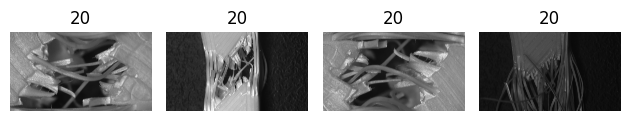

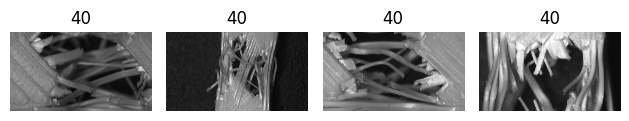

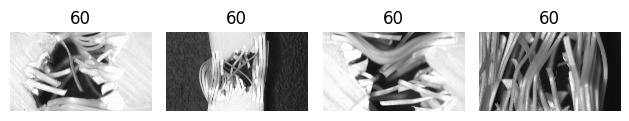

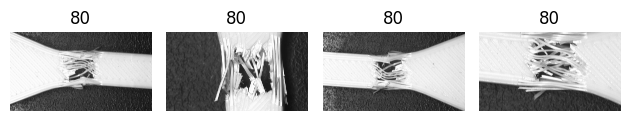

In [3]:
# prompt: display few samples from each of the classes

import matplotlib.pyplot as plt

# Define the number of samples to display per class
num_samples_per_class = 4

# Loop through each class folder
for i, folder in enumerate(input_folders):
  # Get the list of image paths in the folder
  image_paths = glob.glob(os.path.join(output_base_path, folder, '*.tif'))[:num_samples_per_class]

  # Create a figure with subplots
  fig, axes = plt.subplots(1, len(image_paths))

  # Iterate through the selected image paths and display them
  for j, image_path in enumerate(image_paths):
    # Read the image
    image = cv2.imread(image_path, 0)

    # Display the image
    axes[j].imshow(image, cmap='gray')
    axes[j].set_title(folder)
    axes[j].axis("off")

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Display the figure
  plt.show()

In [4]:
import os
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import random

# Paths
data_dir = '/kaggle/input/t-meta/T'  # Change to your directory path
output_dir = '/kaggle/working/images_augmented'

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dataset preparation and augmentation
class AugmentedDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))  # Assumes folders are classes
        self.images = []
        self.labels = []
        self.transform = transform
        self.augment = augment

        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            for file in os.listdir(cls_path):
                if file.endswith('.tif'):
                    self.images.append(os.path.join(cls_path, file))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        # Resize before augmentation
        img = img.resize((224, 224), Image.LANCZOS)

        # Apply augmentations for saving new images
        if self.augment:
            img = self.apply_augmentations(img)

        if self.transform:
            img = self.transform(img)

        return img, label

    def apply_augmentations(self, img):
        # Random augmentations for offline generation
        if random.random() > 0.5:
            img = transforms.functional.hflip(img)
        if random.random() > 0.5:
            img = transforms.functional.rotate(img, angle=random.uniform(-30, 30))
        if random.random() > 0.5:
            img = transforms.functional.adjust_brightness(img, brightness_factor=random.uniform(0.8, 1.2))
        if random.random() > 0.5:
            img = transforms.functional.adjust_contrast(img, contrast_factor=random.uniform(0.8, 1.2))
        return img

def save_augmented_images(dataset, output_dir, num_augments=2):
    for idx, (img, label) in enumerate(dataset):
        cls_name = dataset.classes[label]
        cls_output_dir = os.path.join(output_dir, cls_name)
        os.makedirs(cls_output_dir, exist_ok=True)

        # Save the original resized image
        img_path = os.path.join(cls_output_dir, f'original_{idx}.tif')
        img.save(img_path)

        # Generate and save augmented images
        for i in range(num_augments):
            aug_img = dataset.apply_augmentations(img)
            aug_path = os.path.join(cls_output_dir, f'aug_{idx}_{i}.tif')
            aug_img.save(aug_path)

# Apply augmentations and save offline
raw_dataset = AugmentedDataset(root_dir=data_dir, augment=True)
save_augmented_images(raw_dataset, output_dir, num_augments=2)


In [8]:
# Necessary Imports
import os
import cv2
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Augmentations
from torchvision.transforms import functional as F
import random


# Define transformations for on-the-fly usage
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Ensure compatibility
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Prepare dataset for training
full_dataset = datasets.ImageFolder(output_dir, transform=transform)

# Split into train, validation, and test
train_size = int(0.75 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [9]:
# Load pre-trained Vision Transformer (ViT-B/16)
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# Modify the final classification layer
num_classes = 5  # Replace with your number of classes
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Get parameters of the final classification layer (head)
head_params = list(model.heads.head.parameters())

# Get parameters of the rest of the model (excluding the head)
body_params = [
    p for p in model.parameters()
    if not any(p is hp for hp in head_params)
]

# Define optimizer with different learning rates for each group
optimizer = optim.Adam([
    {"params": head_params, "lr": 0.001},   # Higher LR for final layer
    {"params": body_params, "lr": 0.0001}   # Smaller LR for other layers
])

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss /= total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_loss /= total

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")




Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 233MB/s] 


In [10]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 1/10, Train Loss: 1.1374, Train Acc: 0.5050, Val Loss: 0.8363, Val Acc: 0.6403
Epoch 2/10, Train Loss: 0.5550, Train Acc: 0.7770, Val Loss: 0.4323, Val Acc: 0.8489
Epoch 3/10, Train Loss: 0.3414, Train Acc: 0.8748, Val Loss: 0.3086, Val Acc: 0.8921
Epoch 4/10, Train Loss: 0.1597, Train Acc: 0.9439, Val Loss: 0.2500, Val Acc: 0.9065
Epoch 5/10, Train Loss: 0.1319, Train Acc: 0.9554, Val Loss: 0.4249, Val Acc: 0.8921
Epoch 6/10, Train Loss: 0.1727, Train Acc: 0.9439, Val Loss: 0.2413, Val Acc: 0.8921
Epoch 7/10, Train Loss: 0.1367, Train Acc: 0.9511, Val Loss: 0.2133, Val Acc: 0.9424
Epoch 8/10, Train Loss: 0.0895, Train Acc: 0.9698, Val Loss: 0.0948, Val Acc: 0.9568
Epoch 9/10, Train Loss: 0.0340, Train Acc: 0.9856, Val Loss: 0.1869, Val Acc: 0.9496
Epoch 10/10, Train Loss: 0.0643, Train Acc: 0.9784, Val Loss: 0.0936, Val Acc: 0.9856


Test Accuracy: 96.77%


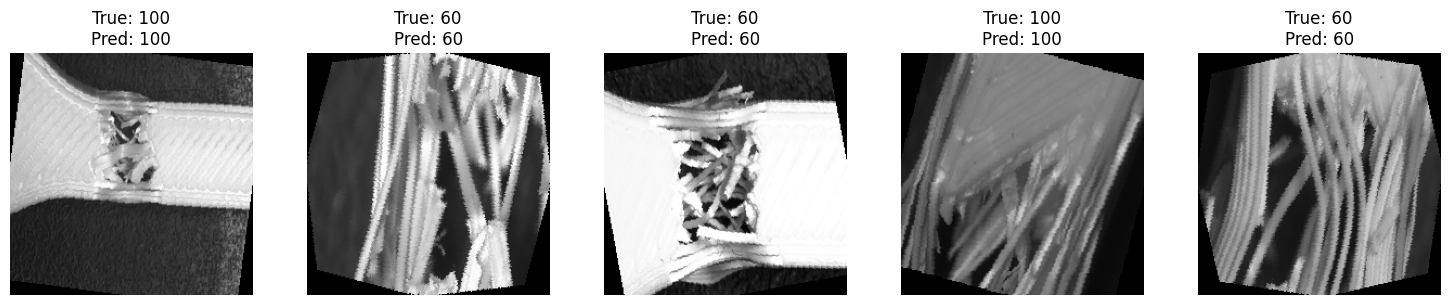

In [25]:
import matplotlib.pyplot as plt

# Label mapping based on folder structure
label_mapping = {0: "100", 1: "20", 2: "40", 3: "60", 4: "80"}

# Denormalize images for display
def denormalize_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406])  # Same mean used in transforms.Normalize
    std = torch.tensor([0.229, 0.224, 0.225])   # Same std used in transforms.Normalize
    image = image * std[:, None, None] + mean[:, None, None]  # Reverse normalization
    return image.clamp(0, 1)  # Clamp values to [0, 1]

# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))  # For displaying 5 images
    num_displayed = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Handle InceptionOutputs (if applicable)
            if isinstance(outputs, tuple):
                outputs = outputs.logits

            _, predicted = outputs.max(1)

            # Calculate accuracy
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            # Display first 5 images with predictions
            if num_displayed < 5:
                for i in range(images.size(0)):
                    if num_displayed >= 5:
                        break

                    # Denormalize the image for visualization
                    img = denormalize_image(images[i].cpu())

                    # Get true and predicted labels using the mapping
                    true_label = label_mapping[labels[i].item()]
                    predicted_label = label_mapping[predicted[i].item()]

                    ax[num_displayed].imshow(img.permute(1, 2, 0))  # Convert to HWC format
                    ax[num_displayed].set_title(
                        f"True: {true_label}\nPred: {predicted_label}"
                    )
                    ax[num_displayed].axis("off")
                    num_displayed += 1

    # Print overall test accuracy
    print(f"Test Accuracy: {100. * correct / total:.2f}%")
    plt.tight_layout()
    plt.show()

# Call the test function
test_model(model, test_loader)

In [24]:
# prompt: save the model

torch.save(model.state_dict(), '//kaggle/working/T_model_ViT_uf.pth')

In [13]:
# Define the model (ResNet-18 with fine-tuning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_rn = models.resnet18(pretrained=True)  # Load ResNet-18
model_rn.fc = nn.Linear(model_rn.fc.in_features, len(full_dataset.classes))  # Adjust output layer
model_rn = model_rn.to(device)

# Define loss function and optimizer
criterion_rn = nn.CrossEntropyLoss()
optimizer_rn = optim.Adam(model_rn.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss /= total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_loss /= total

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


In [26]:
# Train the model
train_model(model_rn, train_loader, val_loader, criterion_rn, optimizer_rn, 5)

Epoch 1/5, Train Loss: 0.0973, Train Acc: 0.9655, Val Loss: 0.4929, Val Acc: 0.8921
Epoch 2/5, Train Loss: 0.0793, Train Acc: 0.9669, Val Loss: 0.4901, Val Acc: 0.8921
Epoch 3/5, Train Loss: 0.0727, Train Acc: 0.9813, Val Loss: 0.2938, Val Acc: 0.8849
Epoch 4/5, Train Loss: 0.0414, Train Acc: 0.9871, Val Loss: 0.1726, Val Acc: 0.9568
Epoch 5/5, Train Loss: 0.0432, Train Acc: 0.9842, Val Loss: 0.2304, Val Acc: 0.9353


Test Accuracy: 94.62%


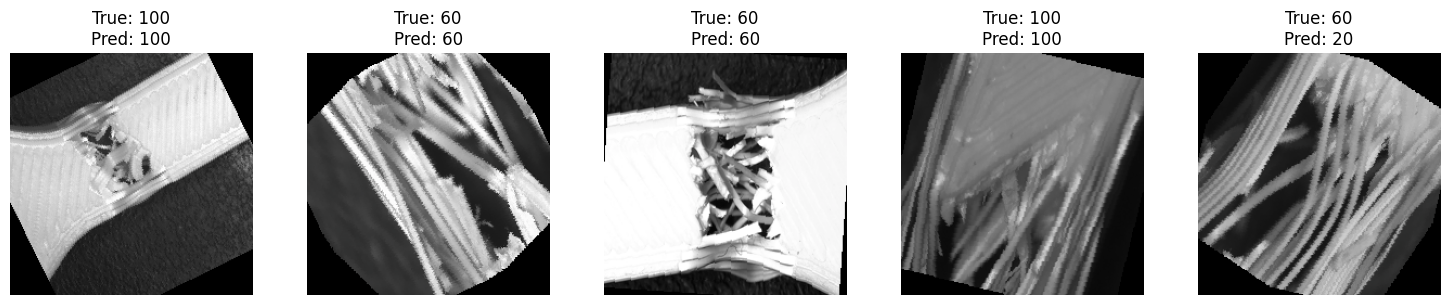

In [27]:
import matplotlib.pyplot as plt

# Label mapping based on folder structure
label_mapping = {0: "100", 1: "20", 2: "40", 3: "60", 4: "80"}

# Denormalize images for display
def denormalize_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406])  # Same mean used in transforms.Normalize
    std = torch.tensor([0.229, 0.224, 0.225])   # Same std used in transforms.Normalize
    image = image * std[:, None, None] + mean[:, None, None]  # Reverse normalization
    return image.clamp(0, 1)  # Clamp values to [0, 1]

# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))  # For displaying 5 images
    num_displayed = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Handle InceptionOutputs (if applicable)
            if isinstance(outputs, tuple):
                outputs = outputs.logits

            _, predicted = outputs.max(1)

            # Calculate accuracy
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            # Display first 5 images with predictions
            if num_displayed < 5:
                for i in range(images.size(0)):
                    if num_displayed >= 5:
                        break

                    # Denormalize the image for visualization
                    img = denormalize_image(images[i].cpu())

                    # Get true and predicted labels using the mapping
                    true_label = label_mapping[labels[i].item()]
                    predicted_label = label_mapping[predicted[i].item()]

                    ax[num_displayed].imshow(img.permute(1, 2, 0))  # Convert to HWC format
                    ax[num_displayed].set_title(
                        f"True: {true_label}\nPred: {predicted_label}"
                    )
                    ax[num_displayed].axis("off")
                    num_displayed += 1

    # Print overall test accuracy
    print(f"Test Accuracy: {100. * correct / total:.2f}%")
    plt.tight_layout()
    plt.show()

# Call the test function
test_model(model_rn, test_loader)

In [16]:
from torchvision.models import googlenet
# Define the model (GoogLeNet with fine-tuning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gn = googlenet(pretrained=True)
model_gn.fc = nn.Linear(model_gn.fc.in_features, len(full_dataset.classes))
model_gn = model_gn.to(device)

# Define loss function and optimizer
criterion_gn = nn.CrossEntropyLoss()
optimizer_gn = optim.Adam(model_gn.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss /= total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_loss /= total

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 159MB/s]


In [17]:
# Train the model
train_model(model_gn, train_loader, val_loader, criterion_gn, optimizer_gn,15)

Epoch 1/15, Train Loss: 1.1100, Train Acc: 0.5036, Val Loss: 0.9637, Val Acc: 0.4748
Epoch 2/15, Train Loss: 0.7817, Train Acc: 0.6791, Val Loss: 1.4798, Val Acc: 0.5108
Epoch 3/15, Train Loss: 0.5780, Train Acc: 0.7799, Val Loss: 0.7634, Val Acc: 0.7194
Epoch 4/15, Train Loss: 0.4882, Train Acc: 0.8230, Val Loss: 0.8983, Val Acc: 0.6763
Epoch 5/15, Train Loss: 0.3961, Train Acc: 0.8504, Val Loss: 0.4182, Val Acc: 0.8417
Epoch 6/15, Train Loss: 0.2386, Train Acc: 0.9252, Val Loss: 0.4348, Val Acc: 0.8705
Epoch 7/15, Train Loss: 0.2215, Train Acc: 0.9194, Val Loss: 0.6383, Val Acc: 0.8129
Epoch 8/15, Train Loss: 0.2156, Train Acc: 0.9252, Val Loss: 1.3793, Val Acc: 0.5683
Epoch 9/15, Train Loss: 0.2951, Train Acc: 0.8993, Val Loss: 0.8130, Val Acc: 0.7338
Epoch 10/15, Train Loss: 0.1943, Train Acc: 0.9338, Val Loss: 0.5838, Val Acc: 0.8561
Epoch 11/15, Train Loss: 0.1224, Train Acc: 0.9655, Val Loss: 0.2540, Val Acc: 0.8993
Epoch 12/15, Train Loss: 0.1198, Train Acc: 0.9568, Val Loss: 0

Test Accuracy: 95.70%


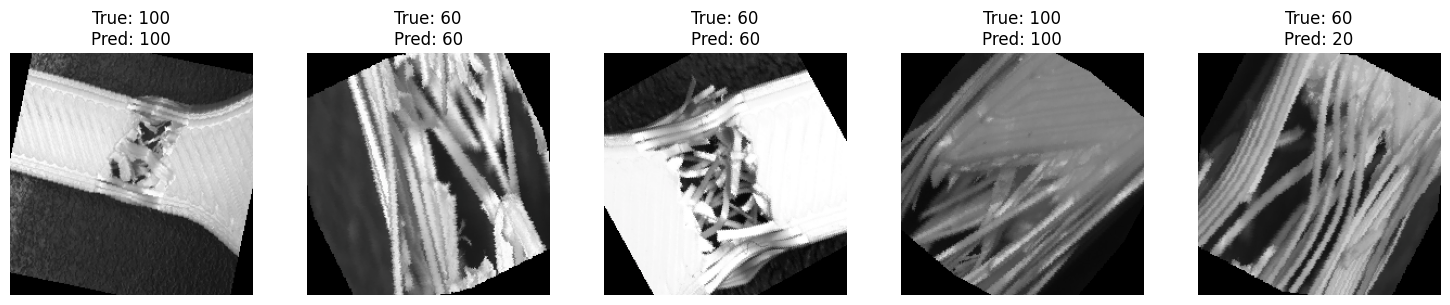

In [18]:
import matplotlib.pyplot as plt

# Label mapping based on folder structure
label_mapping = {0: "100", 1: "20", 2: "40", 3: "60", 4: "80"}

# Denormalize images for display
def denormalize_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406])  # Same mean used in transforms.Normalize
    std = torch.tensor([0.229, 0.224, 0.225])   # Same std used in transforms.Normalize
    image = image * std[:, None, None] + mean[:, None, None]  # Reverse normalization
    return image.clamp(0, 1)  # Clamp values to [0, 1]

# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))  # For displaying 5 images
    num_displayed = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Handle InceptionOutputs (if applicable)
            if isinstance(outputs, tuple):
                outputs = outputs.logits

            _, predicted = outputs.max(1)

            # Calculate accuracy
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            # Display first 5 images with predictions
            if num_displayed < 5:
                for i in range(images.size(0)):
                    if num_displayed >= 5:
                        break

                    # Denormalize the image for visualization
                    img = denormalize_image(images[i].cpu())

                    # Get true and predicted labels using the mapping
                    true_label = label_mapping[labels[i].item()]
                    predicted_label = label_mapping[predicted[i].item()]

                    ax[num_displayed].imshow(img.permute(1, 2, 0))  # Convert to HWC format
                    ax[num_displayed].set_title(
                        f"True: {true_label}\nPred: {predicted_label}"
                    )
                    ax[num_displayed].axis("off")
                    num_displayed += 1

    # Print overall test accuracy
    print(f"Test Accuracy: {100. * correct / total:.2f}%")
    plt.tight_layout()
    plt.show()

# Call the test function
test_model(model_gn, test_loader)

In [19]:
# Define the model (EfficientNet-B0 with fine-tuning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_eff = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)  # Load pretrained EfficientNet-B0

# Modify the classifier
num_ftrs = model_eff.classifier[1].in_features  # Get input features of final layer
model_eff.classifier[1] = nn.Linear(num_ftrs, len(full_dataset.classes))  # Replace final layer
model_eff = model_eff.to(device)

# Define loss function and optimizer
criterion_eff = nn.CrossEntropyLoss()
optimizer_eff = optim.Adam(model_eff.parameters(), lr=0.001)  # Fixed model reference

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss /= total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_loss /= total

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 181MB/s]


In [20]:
# Train the model
train_model(model_eff, train_loader, val_loader, criterion_eff, optimizer_eff,15)

Epoch 1/15, Train Loss: 0.9491, Train Acc: 0.5842, Val Loss: 0.8392, Val Acc: 0.6763
Epoch 2/15, Train Loss: 0.5206, Train Acc: 0.8144, Val Loss: 0.5593, Val Acc: 0.7914
Epoch 3/15, Train Loss: 0.3766, Train Acc: 0.8806, Val Loss: 0.3082, Val Acc: 0.9065
Epoch 4/15, Train Loss: 0.2354, Train Acc: 0.9180, Val Loss: 0.1877, Val Acc: 0.9209
Epoch 5/15, Train Loss: 0.1487, Train Acc: 0.9525, Val Loss: 0.2133, Val Acc: 0.8993
Epoch 6/15, Train Loss: 0.1638, Train Acc: 0.9540, Val Loss: 0.1966, Val Acc: 0.9209
Epoch 7/15, Train Loss: 0.1758, Train Acc: 0.9453, Val Loss: 0.2285, Val Acc: 0.9568
Epoch 8/15, Train Loss: 0.1299, Train Acc: 0.9626, Val Loss: 0.1564, Val Acc: 0.9353
Epoch 9/15, Train Loss: 0.1228, Train Acc: 0.9583, Val Loss: 0.0846, Val Acc: 0.9640
Epoch 10/15, Train Loss: 0.0530, Train Acc: 0.9871, Val Loss: 0.0469, Val Acc: 0.9928
Epoch 11/15, Train Loss: 0.0951, Train Acc: 0.9799, Val Loss: 0.0598, Val Acc: 0.9712
Epoch 12/15, Train Loss: 0.1385, Train Acc: 0.9554, Val Loss: 0

Test Accuracy: 97.85%


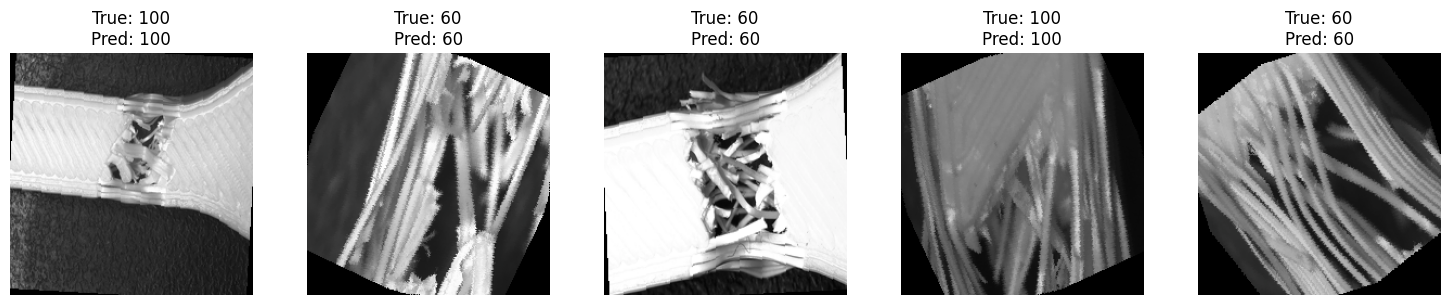

In [21]:
import matplotlib.pyplot as plt

# Label mapping based on folder structure
label_mapping = {0: "100", 1: "20", 2: "40", 3: "60", 4: "80"}

# Denormalize images for display
def denormalize_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406])  # Same mean used in transforms.Normalize
    std = torch.tensor([0.229, 0.224, 0.225])   # Same std used in transforms.Normalize
    image = image * std[:, None, None] + mean[:, None, None]  # Reverse normalization
    return image.clamp(0, 1)  # Clamp values to [0, 1]

# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))  # For displaying 5 images
    num_displayed = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Handle InceptionOutputs (if applicable)
            if isinstance(outputs, tuple):
                outputs = outputs.logits

            _, predicted = outputs.max(1)

            # Calculate accuracy
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            # Display first 5 images with predictions
            if num_displayed < 5:
                for i in range(images.size(0)):
                    if num_displayed >= 5:
                        break

                    # Denormalize the image for visualization
                    img = denormalize_image(images[i].cpu())

                    # Get true and predicted labels using the mapping
                    true_label = label_mapping[labels[i].item()]
                    predicted_label = label_mapping[predicted[i].item()]

                    ax[num_displayed].imshow(img.permute(1, 2, 0))  # Convert to HWC format
                    ax[num_displayed].set_title(
                        f"True: {true_label}\nPred: {predicted_label}"
                    )
                    ax[num_displayed].axis("off")
                    num_displayed += 1

    # Print overall test accuracy
    print(f"Test Accuracy: {100. * correct / total:.2f}%")
    plt.tight_layout()
    plt.show()

# Call the test function
test_model(model_eff, test_loader)